# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Define transforms
transform = transforms.Compose(
  [transforms.ToTensor(),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                    download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,
                      shuffle=True, num_workers=2)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=5,
                     shuffle=False, num_workers=2)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [12]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].


truck


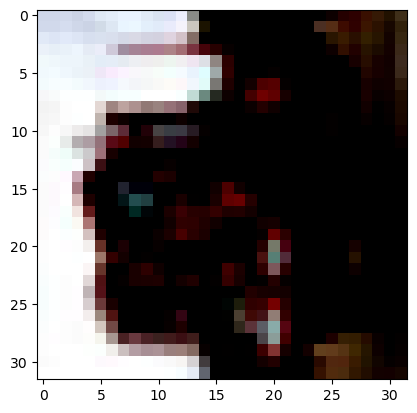

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.99215686].


cat


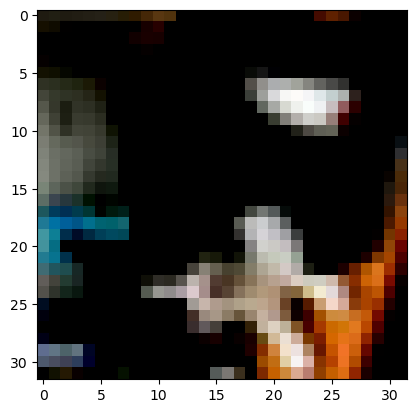

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].


truck


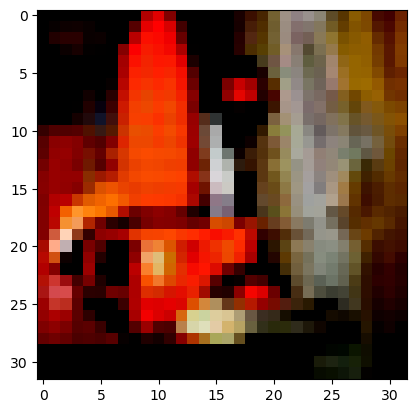

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].


bird


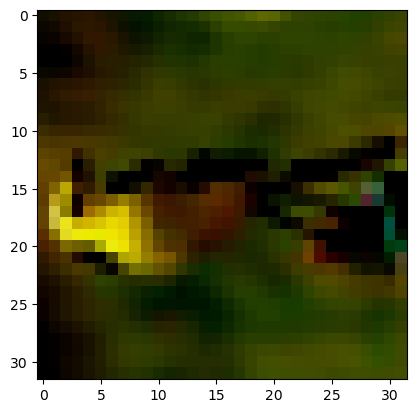

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.67058825].


horse


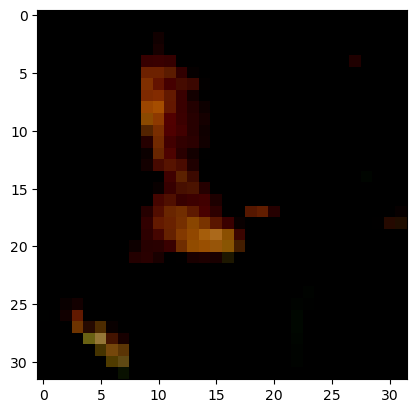

In [13]:
# Explore data
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.fc1 = nn.Linear(128 * 4 * 4, 512)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.pool(F.relu(self.bn3(self.conv3(x))))
    x = x.view(-1, 128 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss is suitable for multi-class classification tasks
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

num_epochs = 10
for epoch in range(num_epochs):  # loop over the dataset multiple times
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 250 == 249:    # print every 250 mini-batches
      print(f"[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 250:.3f}")
      running_loss = 0.0

print('Finished Training')

[Epoch 1, Batch 250] loss: 2.230
[Epoch 1, Batch 500] loss: 2.055
[Epoch 1, Batch 750] loss: 1.993
[Epoch 1, Batch 1000] loss: 1.910
[Epoch 1, Batch 1250] loss: 1.914
[Epoch 1, Batch 1500] loss: 1.852
[Epoch 1, Batch 1750] loss: 1.830
[Epoch 1, Batch 2000] loss: 1.792
[Epoch 1, Batch 2250] loss: 1.756
[Epoch 1, Batch 2500] loss: 1.794
[Epoch 1, Batch 2750] loss: 1.746
[Epoch 1, Batch 3000] loss: 1.657
[Epoch 1, Batch 3250] loss: 1.667
[Epoch 1, Batch 3500] loss: 1.660
[Epoch 1, Batch 3750] loss: 1.669
[Epoch 1, Batch 4000] loss: 1.627
[Epoch 1, Batch 4250] loss: 1.587
[Epoch 1, Batch 4500] loss: 1.592
[Epoch 1, Batch 4750] loss: 1.575
[Epoch 1, Batch 5000] loss: 1.588
[Epoch 1, Batch 5250] loss: 1.547
[Epoch 1, Batch 5500] loss: 1.565
[Epoch 1, Batch 5750] loss: 1.507
[Epoch 1, Batch 6000] loss: 1.485
[Epoch 1, Batch 6250] loss: 1.488
[Epoch 1, Batch 6500] loss: 1.458
[Epoch 1, Batch 6750] loss: 1.467
[Epoch 1, Batch 7000] loss: 1.503
[Epoch 1, Batch 7250] loss: 1.459
[Epoch 1, Batch 7

Plot the training loss (and validation loss/accuracy, if recorded).

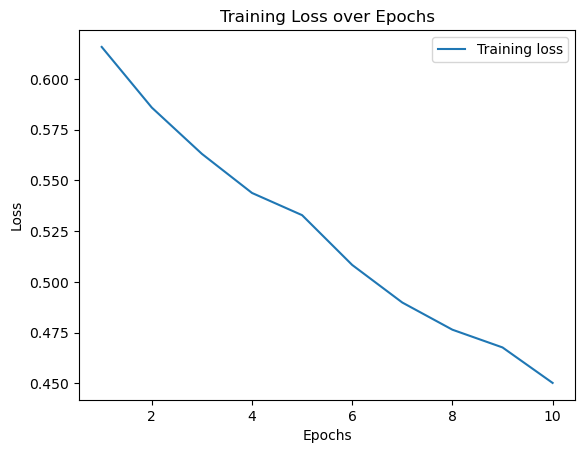

In [9]:
# Assuming the training loss was recorded during the initial training process Assuming
epochs = range(1, num_epochs + 1)
train_losses = []

# Re-run the training loop to collect loss data
for epoch in range(num_epochs):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  train_losses.append(running_loss / len(trainloader))

plt.plot(epochs, train_losses, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 10000 test images: 72.78%


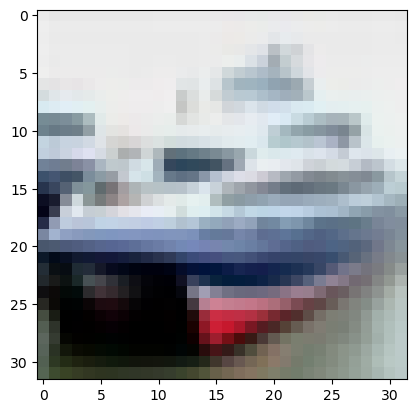

True label: ship
Predicted label: ship


In [16]:
# Get a random test image
dataiter = iter(testloader)
images, labels = next(dataiter)

# Display the image
img = images[1] / 2 + 0.5  # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

# Print the true label
print(f'True label: {classes[labels[1]]}')

# Predict the label
images = images.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Print the predicted label
print(f'Predicted label: {classes[predicted[1]]}')

## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
torch.save(net.state_dict(), 'cifar_net.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Our model achieved an accuracy of 72.78% on the CIFAR-10 test dataset. Compared to the benchmark results, our model's performance is lower than the state-of-the-art models, which achieve accuracies ranging from 78.9% to 99.0%. Given the significant gap between our model's accuracy and the top-performing models, it may be more practical to consider using a pre-trained model or purchasing an object detection solution to achieve higher accuracy and save on development time and resources.